In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### Self-attention

In [8]:
n = 15  # number of tokens
d_model, d_attn, d_value = 5, 4, 16 # dm, da, dv
scale = 1.0 / np.sqrt(d_attn)
X = torch.randn(n, d_model)
Wq = torch.randn(d_model, d_attn)
Wk = torch.randn(d_model, d_attn)
Wv = torch.randn(d_model, d_value)

def self_attention(X, Wq, Wk, Wv, scale=1.0):
    Q = X @ Wq * scale # [n, da]
    K = X @ Wk * scale # [n, da]
    V = X @ Wv # [n, dv]
    scores = Q @ K.T # or torch.einsum('il,jl->ij', Q, K); [n,n]              
    attn = torch.softmax(scores, axis=1) # [n,n]
    Y = attn @ V # or torch.einsum('ij,jd->id', attn, V); [n, dv]
    return Y

Y = self_attention(X, Wq, Wk, Wv, scale=scale)

### Tensor-based self-attention

In [9]:
Wk1 = torch.randn(d_model, d_attn)
Wk2 = torch.randn(d_model, d_attn)

def self_attention_3d(X, Wq, Wk1, Wk2, Wv):
    Q = X @ Wq # [n, da]
    K1 = X @ Wk1 # [n, da]
    K2 = X @ Wk2 # [n, da]
    V = X @ Wv # [n, dv]
    scores = torch.einsum('il,jl,kl->ijk', Q, K1, K2) # [n, n, n]
    attn = torch.softmax(scores.reshape(n, -1), dim=1).reshape(n, n, n) # [n, n, n]
    Vjk = torch.cat([V.unsqueeze(1)+V.unsqueeze(0)], dim=0) # [n, n, dv]
    Y = torch.einsum('ijk,jkd->id', attn, Vjk) # [n, dv]
    return Y

Y_3d = self_attention_3d(X, Wq, Wk1, Wk2, Wv)

### RFA Attention

In [12]:
def rff_attention(X, Wq, Wk, Wv, sigma=1.0, N=1024, eps=1e-8):
    Q = X @ Wq # [n, da]
    K = X @ Wk # [n, da]
    V = X @ Wv # [n, dv]
    omega = torch.randn(d_attn, N) / sigma # [da, N]

    def phi(T): 
        TOm = T @ omega # [n, N]
        return torch.cat([torch.cos(TOm), torch.sin(TOm)], -1) / N**0.5 # [n, 2N]

    phiQ = phi(Q)  # [n, 2N]
    phiK = phi(K)  # [n, 2N]
    CK = torch.exp((K**2).sum(axis=1, keepdims=True) / (2 * sigma**2)) # [n, 1]
    S = (phiK*CK).T @ V  # [2N, dv]
    D = torch.sum(phiK * CK, axis=0, keepdim=True) # [1, 2N]
    
    denom = phiQ @ D.T  # [n, 1]
    numer = phiQ @ S    # [n, dv]
    return numer / (denom + eps)

Y_rfa = rff_attention(X, Wq, Wk, Wv, sigma=1/scale, N=64)

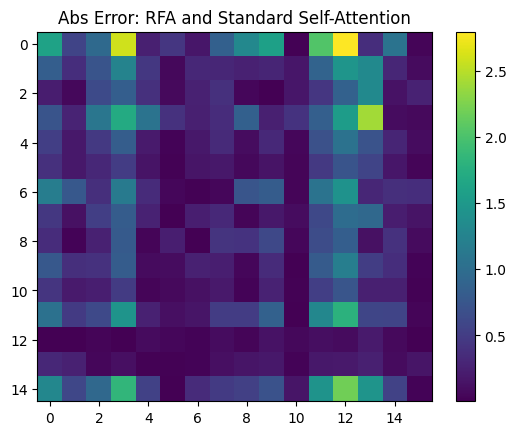

In [13]:
plt.imshow(torch.abs(Y_rfa - Y).detach().numpy())
plt.title('Abs Error: RFA and Standard Self-Attention')
plt.colorbar()

### Multidimensional RFA Kernel

In [32]:
n, d = 5, 50
x = torch.randn(n, d)

def k_mc(x, sigma=1.0, N=128):
    n, d = x.shape
    diffs = x[1:] - x[0] # [n-1, d]
    omegas = torch.randn(n-1, d, N) / sigma

    m = torch.einsum('ij,ijk->ik', diffs, omegas) # [n-1, N]
    phi = torch.cat([torch.cos(m), torch.sin(m)], -1) / N**0.5 # [n-1, 2N]
    return torch.mean(torch.prod(phi, dim=0))

def k_exact(x, sigma=1.0):
    diffs = x[1:] - x[0] # [n-1, d]
    return torch.exp(-0.5 * sigma**2 * torch.sum(diffs**2))

f = lambda : torch.norm(k_mc(x, sigma=1.0, N=16) - k_exact(x, sigma=1.0)).item()
errors = np.array([f() for _ in range(1000)])
print(f"L2 Error mean: {errors.mean():.9f}", f"std: {errors.std():.9f}")

L2 Error mean: 0.000141528 std: 0.000105931


In [66]:
n, d = 100, 5 # Total data points and data dimension
m = 20 # number of inducing points
X = torch.randn(n, d)
rbf = lambda X, Y: torch.exp(-0.5 * torch.cdist(X, Y)**2)

# Nyström approximation
Y = torch.randn(m, d)
K_mm = rbf(Y, Y)
eigvals, eigvecs = torch.linalg.eigh(K_mm)
K_mm_inv_sqrt = eigvecs @ torch.diag(1/torch.sqrt(torch.clamp(eigvals, 1e-5))) @ eigvecs.T

phi = K_mm_inv_sqrt @ rbf(X, Y).T  # [N, m]
K_approx = phi.T @ phi
K_exact = rbf(X, X)

error = torch.linalg.norm(K_exact - K_approx, 'fro')/torch.linalg.norm(K_exact, 'fro')
print(f"Relative error: {error:.4f}")

Relative error: 0.5879


In [67]:
m, d, r = 24, 4, 8                 # #landmarks, dim, rank
Z = torch.randn(m, d)

def K3(x, y, z):
    # S[i,j,k] = ||x_i-y_j||^2 + ||y_j-z_k||^2 + ||z_k-x_i||^2
    xy = torch.cdist(x, y) ** 2        # [nx, ny]
    yz = torch.cdist(y, z) ** 2        # [ny, nz]
    xz = torch.cdist(x, z) ** 2        # [nx, nz]
    S = xy[:, :, None] + yz[None, :, :] + xz[:, None, :]
    return torch.exp(-0.5 * S)         # [nx, ny, nz]

# --- landmark tensor ---
T = K3(Z, Z, Z)                        # [m, m, m]

# --- SVD/eig-based orthogonal CP init (replaces power iterations) ---
M = T.reshape(m, -1)                   # mode-1 unfolding [m, m^2]
evals, Ufull = torch.linalg.eigh(M @ M.T)   # PSD Gram
idx = torch.argsort(evals, descending=True)[:r]
U = Ufull[:, idx]                      # [m, r] (orthonormal)
S = torch.einsum('abc,ar,br,cr->r', T, U, U, U).clamp_min(1e-12)  # weights

# --- reconstruction check on landmarks ---
T_hat = torch.einsum('ir,jr,kr,r->ijk', U, U, U, S)
rel_err_landmarks = torch.linalg.norm(T - T_hat) / torch.linalg.norm(T)

# --- Nyström features for new points ---
# Using: g_i(x) := Σ_{b,c} K3(x,z_b,z_c) u_i[b]u_i[c] ≈ λ_i φ_i(x), so ψ_i(x)=λ_i^{-2/3} g_i(x)
def psi(x):                             # x: [n,d] -> [n,r]
    Kxz = K3(x, Z, Z)                   # [n, m, m]
    g = torch.einsum('nmn,br,cr->nr', Kxz, U, U)
    return g * (S ** (-2/3))

# --- evaluate approximation on triples (X[i], Y[i], W[i]) ---
n = 10
X = torch.randn(n, d); Y = torch.randn(n, d); W = torch.randn(n, d)
K_xyz = K3(X, Y, W)
idx = torch.arange(n)
K_exact = K_xyz[idx, idx, idx]         # length-n: K3(X[i],Y[i],W[i])

PX, PY, PW = psi(X), psi(Y), psi(W)
K_approx = torch.sum(PX * PY * PW, dim=1)

rel_err_new = torch.linalg.norm(K_exact - K_approx) / torch.linalg.norm(K_exact)
print(f"Rel. landmark tensor error: {rel_err_landmarks:.4f}")
print(f"Rel. new-point triple error: {rel_err_new:.4f}")

RuntimeError: einsum(): subscript n is repeated for operand 0 but the sizes don't match, 24 != 10

In [68]:
m, d, r = 24, 4, 8                 # landmarks, dim, truncated rank
Z = torch.randn(m, d)              # landmarks
rbf = lambda A,B: torch.cdist(A,B)**2
# A simple symmetric 3-ary kernel (sum of pairwise RBF distances)
def K3(x,y,z): 
    return torch.exp(-0.5*(rbf(x,y)+rbf(y,z)+rbf(z,x)))

# landmark tensor T[a,b,c] = K3(z_a,z_b,z_c)
T = K3(Z,Z,Z)

# --- Symmetric tensor power method (rank-r CP) ---
U, S = [], []
R = T.clone()
for _ in range(r):
    u = torch.randn(m); u = u/torch.norm(u)
    for _ in range(25):
        # mode-1 contraction: v_a = sum_{b,c} R[a,b,c]*u_b*u_c
        v = torch.tensordot(R, u, dims=([1],[0]))
        v = torch.tensordot(v, u, dims=([1],[0]))
        u = v / (torch.norm(v)+1e-12)
    s = torch.tensordot(R, torch.ger(u,u).unsqueeze(2)*u, dims=R.ndim)  # s = <R, u⊗u⊗u>
    R = R - s * torch.einsum('a,b,c->abc', u,u,u)                        # deflate
    U.append(u); S.append(s)
U, S = torch.stack(U,1), torch.clamp(torch.tensor(S), min=1e-12)         # U: [m,r], S: [r]

# --- Landmark reconstruction check ---
T_hat = torch.einsum('ir,jr,kr,r->ijk', U,U,U,S)
rel_err_landmarks = torch.linalg.norm(T - T_hat) / torch.linalg.norm(T)

# Nyström features ψ_i(x) ≈ λ_i^{1/3} φ_i(x)
# Using: g_i(x) := Σ_{b,c} K3(x,z_b,z_c) u_i[b]u_i[c] ≈ λ_i φ_i(x)
# hence ψ_i(x) = λ_i^{-2/3} g_i(x)
def psi(x):                       # x: [n,d] -> [n,r]
    Kxz = K3(x, Z, Z)             # [n,m,m]
    g   = torch.einsum('nmn,br,cr->nr', Kxz, U, U)   # contract with u⊗u
    return g * (S**(-2/3))

# Example: approximate K3(x,y,z) ≈ Σ_i ψ_i(x)ψ_i(y)ψ_i(z)
n = 10
X = torch.randn(n,d); Y = torch.randn(n,d); W = torch.randn(n,d)
K_exact = K3(X,Y,W).diagonal()    # size n (pairwise triples)
PX, PY, PW = psi(X), psi(Y), psi(W)
K_approx = torch.sum(PX*PY*PW, dim=1)

rel_err_new = torch.linalg.norm(K_exact - K_approx)/torch.linalg.norm(K_exact)
print(f"Rel. landmark tensor error: {rel_err_landmarks:.4f}")
print(f"Rel. new-point triple error: {rel_err_new:.4f}")

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)